## Important

Right now, the model predicts a static output vector (of size 100) given a temporal input (100 timesteps of voltages + 6 params).
It’s not predicting the next voltages over time, it’s mapping a temporal pattern to an output vector. It's not autoregressive.

Future devlopment:
- Goal: 
$$
v_{t+1} = f(v_{t}, v_{t-1}, \ldots, v_{t-w}, \text{params})
$$
- Use https://snntorch.readthedocs.io/en/latest/snn.neurons_rleaky.html
- Feed the model a window of previous timesteps, and have it predict the next one:
```python
for t in range(window, total_steps - 1):
    input = volt[:, t - window:t, :]
    target = volt[:, t + 1, :]
```

Questions:
- Do I have the 6 static parameter during inference?
- the mdoel shoult be autoregressive right? I.e. given a tiem sequence predict the next "token".

In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as L

from pytorch_lightning import Trainer
import wandb

import os

In [2]:
print(snn.__version__)
print(torch.__version__)

0.9.4
2.8.0


## 0. Execute in shell

```sh
wandb login
``` 

# 1. Prepare Data

In [3]:
# Our data in in the shape: trainings samples(28k) * number of time steps (100 + 6) * time dimension(1)
# The time steps is voltage over time
data = torch.load(f'./data/dataset.ds')

print(data.keys())
print(data['X_train'].shape)
print(data['Y_train'].shape)

dict_keys(['X_train', 'Y_train', 'X_valid', 'Y_valid', 'X_test', 'Y_test'])
torch.Size([28797, 106, 1])
torch.Size([28797, 100])


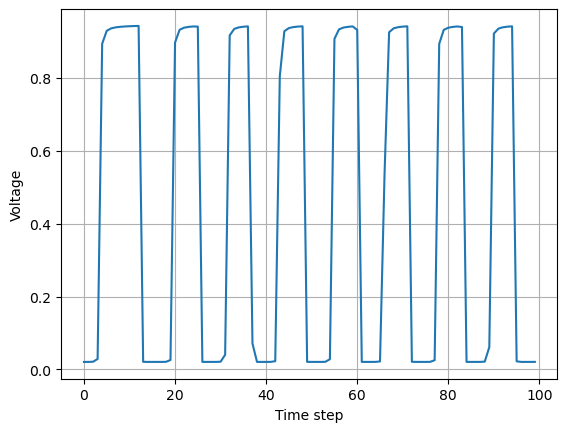

In [4]:
X_train = data['X_train'][1].squeeze().numpy()[:-6] # last 6 are parameters of the simulation i.e. not voltage

plt.plot(X_train)
plt.xlabel("Time step")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()

In [5]:
# Extract tensors
X_train, Y_train = data['X_train'], data['Y_train']
X_valid, Y_valid = data['X_valid'], data['Y_valid']
X_test, Y_test = data['X_test'], data['Y_test']

train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid, Y_valid)
test_dataset  = TensorDataset(X_test, Y_test)

## 2. Network definition

In [6]:
class SpikeSynth(L.LightningModule):
    def __init__(self, num_hidden, beta, optimizer_class, lr, batch_size, gamma):
        super().__init__()
        self.num_voltage_steps = 100
        self.num_voltage_steps = 100
        self.num_params = 6
        self.num_inputs = 1
        self.num_outputs = 100
        
        # Save hyperparameters for easy access
        self.save_hyperparameters()

        # Network layers
        self.linear0 = nn.Linear(self.num_inputs, self.hparams.num_hidden)
        self.lif0 = snn.Leaky(beta=self.hparams.beta)
        self.linear1 = nn.Linear(self.hparams.num_hidden, self.hparams.num_hidden)
        self.lif1 = snn.Leaky(beta=self.hparams.beta)
        self.linear2 = nn.Linear(self.hparams.num_hidden, self.hparams.num_hidden)
        self.lif2 = snn.Leaky(beta=self.hparams.beta)
        self.linear3 = nn.Linear(self.hparams.num_hidden + self.num_params, self.num_outputs)


    def forward(self, x):
        volt = x[:, :self.num_voltage_steps, :]
        params = x[:, self.num_voltage_steps:, 0]

        mem0 = self.lif0.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        mem_rec = []
        for step in range(self.num_voltage_steps):
            x_step = self.linear0(volt[:, step, :])
            spk, mem0 = self.lif0(x_step, mem0)

            x_step = self.linear1(spk)
            spk, mem1 = self.lif1(x_step, mem1)
            
            x_step = self.linear2(spk)
            spk, mem2 = self.lif2(x_step, mem2)

            mem_rec.append(mem2)

        mem_final = torch.stack(mem_rec, dim=0)[-1]
        combined = torch.cat((mem_final, params), dim=1)
        out = self.linear3(combined)
        return out

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = torch.nn.MSELoss()(outputs, y_batch.float())
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = torch.nn.MSELoss()(outputs, y_batch.float())
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        opt = self.optimizers()
        lr = opt.param_groups[0]["lr"]
        
        # Log the learning rate to W&B or progress bar
        self.log("lr", lr, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        optimizer = self.hparams.optimizer_class(self.parameters(), lr=self.hparams.lr)
        
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, mode='min'
        #)
        
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=self.hparams.gamma
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=8,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=4,
        )

### Legacy code: waiting for Pytorch 2.9.0 in nixpkgs to be relased, before Muon can be used

See: https://github.com/NixOS/nixpkgs/pull/452357

```python
def configure_optimizers(self):
        # Separate Muon-compatible and incompatible parameters
        muon_params, other_params = [], []
        for name, param in self.named_parameters():
            if param.dim() > 1:  # Muon only supports matrix-like weights
                muon_params.append(param)
            else:
                other_params.append(param)
    
        # Create optimizers
        muon_opt = torch.optim.Muon(
            muon_params,
            lr=self.hparams.lr,
        )
    
        # Fallback optimizer for biases, norms, embeddings, etc.
        other_opt = torch.optim.AdamW(other_params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
    
        # Scheduler (shared for both, optional)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            muon_opt, gamma=self.hparams.gamma
        )
    
        # Lightning will handle multiple optimizers automatically
        return [
            {"optimizer": muon_opt, "lr_scheduler": scheduler, "monitor": "val_loss"},
            {"optimizer": other_opt},
        ]
```

In [11]:
num_hidden=10 
beta=0.9
lr=1e-3
gamma=0.95
batch_size = 2048

optimizer_class = torch.optim.AdamW

experiment_name = "Debug"
epochs = 2

In [12]:
model = SpikeSynth(
    num_hidden=num_hidden,
    beta=beta,
    optimizer_class=optimizer_class,
    lr=lr,
    batch_size=batch_size,
    gamma=gamma
)

model = torch.compile(model)

In [13]:
# Create a CometLogger instance
wandb_logger = WandbLogger(
                          log_model=True,
                          project="Spike-Synth",
                          name=experiment_name,
                          )

# log gradients and model topology
wandb_logger.watch(model)
wandb_logger.experiment.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


<Artifact source-Spike-Synth-surrogate_Lighning_Pipeline.ipynb>

In [14]:
trainer = Trainer(
    # fast_dev_run=True,
    max_epochs=epochs,
    logger=wandb_logger,  
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

# Train the model
trainer.fit(model)

wandb_logger.experiment.finish()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | linear0 | Linear | 20     | train
1 | lif0    | Leaky  | 0      | train
2 | linear1 | Linear | 110    | train
3 | lif1    | Leaky  | 0      | train
4 | linear2 | Linear | 110    | train
5 | lif2    | Leaky  | 0      | train
6 | linear3 | Linear | 1.7 K  | train
-------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: | | 0/? [00:00<?

/nix/store/qsg98l1y41k4530xsn0ss82xrd03095c-python3-3.12.11-env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: | | 0/? [00:00<?, ?it/s

Validation: | | 0/? [00:00<?, ?it

Validation: | | 0/? [00:00<?, ?it

`Trainer.fit` stopped: `max_epochs=2` reached.


epoch,▁▁██
lr,█▁
train_loss,█▁
trainer/global_step,▁▁██
val_loss,█▁
epoch,1
lr,0.0009
train_loss,0.29196
trainer/global_step,29
val_loss,0.25518


## 2. Test Trained Model

In [11]:
import wandb
run = wandb.init()
# artifact = run.use_artifact('lupos/Spike-Synth/model-hw0qwqcl:best', type='model') # Expoential-Decay ID: hw0qwqcl 

artifact = run.use_artifact('lupos/Spike-Synth/model-zgjoc64u:v0', type='model') # Expoential-Decay ID: hw0qwqcl

artifact_dir = artifact.download()
print("Model downloaded to:", artifact_dir)

wandb: Downloading large artifact 'model-zgjoc64u:v0', 187.07MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.5 (370.0MB/s)


Model downloaded to: /home/monkeman/SpikeSynth/surrogate/artifacts/model-zgjoc64u:v0


In [12]:
# Provide full path to the checkpoint
checkpoint_path = f"{artifact_dir}/model.ckpt"

model = SpikeSynth.load_from_checkpoint(checkpoint_path)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): SpikeSynth(
    (linear0): Linear(in_features=1, out_features=10, bias=True)
    (lif0): Leaky()
    (linear1): Linear(in_features=10, out_features=10, bias=True)
    (lif1): Leaky()
    (linear2): Linear(in_features=10, out_features=10, bias=True)
    (lif2): Leaky()
    (linear3): Linear(in_features=16, out_features=100, bias=True)
  )
)

In [13]:
single_input = valid_dataset[0][0].unsqueeze(0)  # add batch dimension

with torch.no_grad():
    output = model(single_input)
    print("Predicted output:", output)

Predicted output: tensor([[ 0.2802,  0.0194, -0.7543,  0.2610,  0.4139, -0.3834,  0.5898, -1.3490,
          0.6915,  0.2274,  1.1546, -0.0686, -0.0475,  0.1461,  0.1539,  0.0651,
          0.2057, -1.0821,  0.4678, -0.1221,  0.0473,  0.3938, -0.1005, -0.0333,
          0.6869,  0.4840,  0.5337, -0.0786,  0.1513,  0.0134, -0.2623,  0.1620,
          0.3449, -0.1062,  0.1990, -0.0391, -0.4024,  0.4392,  0.5431,  0.3840,
         -0.0872, -0.4727,  0.0428,  0.1550, -0.2296, -0.0085, -0.3109,  0.1289,
         -0.2115, -0.3091, -0.1044, -0.4813,  0.2702, -0.3137,  0.1748, -0.3820,
          0.1156,  0.6316,  0.1958,  0.1671,  0.4214,  0.3646, -0.2235,  0.4500,
          0.3061,  0.1322,  0.3717, -0.4639,  0.1896,  0.3286, -0.3003,  1.0734,
          0.1973,  0.2376, -0.5263,  0.0267,  0.4099,  0.2130,  0.5151, -0.3419,
          0.8086,  0.3089,  0.4675,  0.0463,  0.4259,  0.3675, -0.6637,  0.2846,
          0.1029,  0.1774,  0.0776,  0.2403,  0.2032,  0.8268,  0.3003,  0.2939,
         -

## 3. Wandb Sweep

This is for hyperparamitzation search